#Project 1: Gradient-based Algorithms and Differentiable Programming

###Problem formulation

In order to get a better dynamic model, let us consider a simple rocket landing motion (vertical landing) considering drag,gravity and thrust.

Rocket state,$x(t)=\begin{bmatrix} d(t) \\ v(t) \end{bmatrix}$<br/>
Where,<br/>$t=$ time<br/> $d(t)=$ distance between rocket and the ground at time $t$<br/>
$v(t)=$ velocity of the rocket at time $t$<br/>
Discrete time dynamics,<br/>
$$d(t+1)=d(t)+v(t)\Delta t$$<br/>
$$v(t+1)=v(t)+gravity(\Delta t)+(drag-thrust)a(t)\Delta t$$<br/>
Where,<br/> $a(t)=$ acceleration of rocket at time $t$ . It is the control input of the rocket<br/>
$\Delta t =$time interval<br/><br/>
Closed loop controller,<br/>
$a(t)=f_{\theta}(x(t))$<br/>
Where,<br/>
$f_{\theta}(.)=$neural network with parameters $\theta$, which are to be determined through optimization <br/>
For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.<br/>
The optimization problem is now formulated as,<br/>
$\begin{aligned} \min_{\theta} \quad &  ||x(T)||^2 \\ \implies \min_{\theta} \quad & (d(T))^2 + (v(T))^2 \\ \quad & d(t+1)=d(t)+v(t)\Delta t \\ \quad &v(t+1)=v(t)+gravity(\Delta t)+(drag-thrust)a(t) \Delta t,\\ \quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1  \end{aligned} $<br/><br/>
Variable and values assumed,<br/>
Time interval, $\Delta t = 1$ <br/>
$Gravity=9.81 / 1000 $ <br/>
$thrust=14.715 / 1000$<br/>
$drag=1/1000$<br/>
Final time, $T=20$<br/>


### Programming and analysis of result

In [49]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [86]:
FRAME_TIME = 1  # time interval
GRAVITY_ACCEL = 9.81/1000  # gravity constant
BOOST_ACCEL = 14.715/1000  # thrust constant
DRAG = 1/1000 #drag constant 
class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state, action):
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        delta_state = (DRAG - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action
        state = state + delta_state + delta_state_gravity
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)
        return state
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )
    def forward(self, state):
        action = self.network(state)
        return action
class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)
    @staticmethod
    def initialize_state():
        state = [1., 0.]  
        return t.tensor(state, requires_grad=False).float()
    def error(self, state):
        return state[0]**2 + state[1]**2
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.l = []
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            lo=loss.clone().detach()
            self.l.append(lo)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[1] loss: 6.729


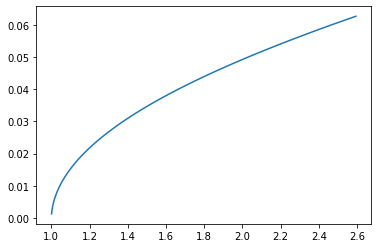

[2] loss: 3.315


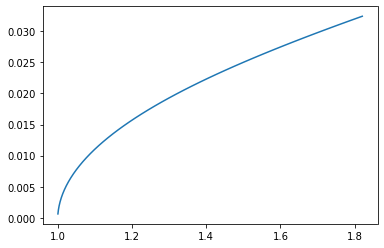

[3] loss: 1.794


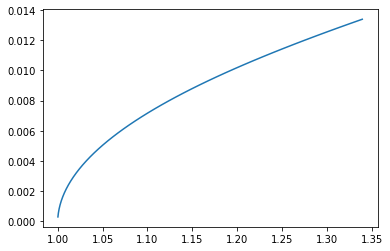

[4] loss: 0.981


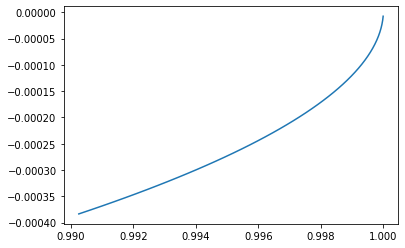

[5] loss: 0.556


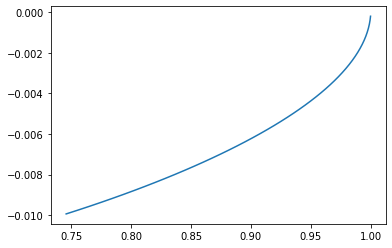

[6] loss: 0.326


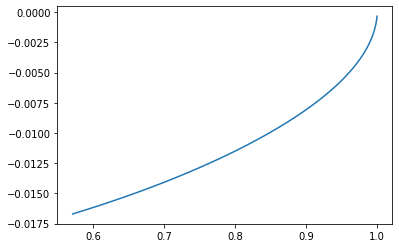

[7] loss: 0.186


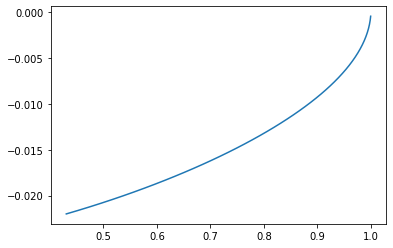

[8] loss: 0.104


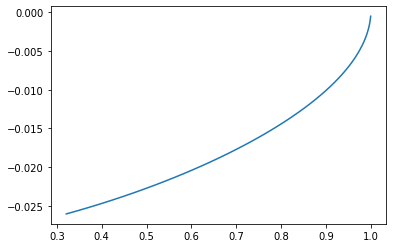

[9] loss: 0.061


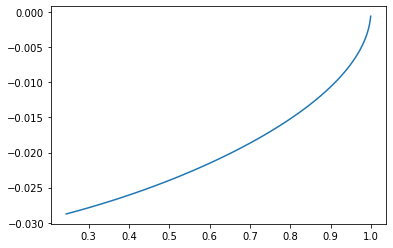

[10] loss: 0.037


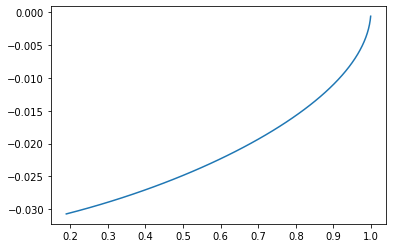

[11] loss: 0.023


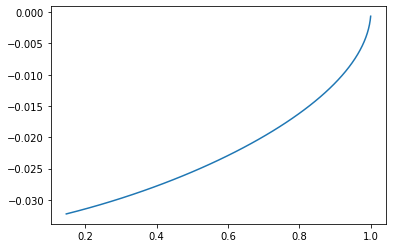

[12] loss: 0.014


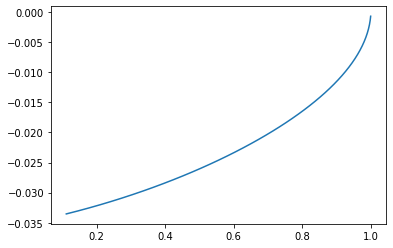

[13] loss: 0.008


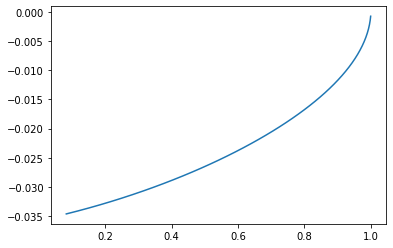

[14] loss: 0.005


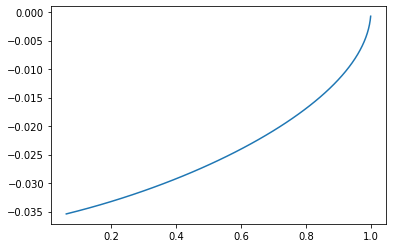

[15] loss: 0.003


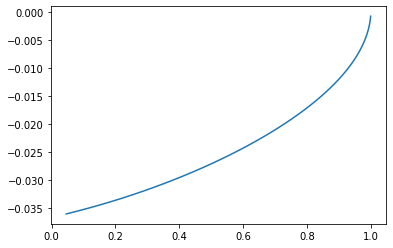

[16] loss: 0.003


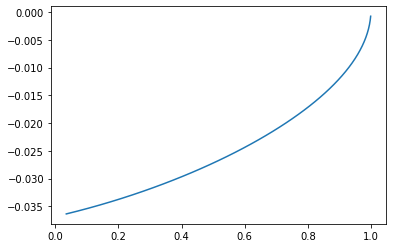

[17] loss: 0.002


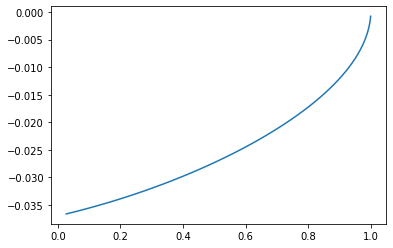

[18] loss: 0.002


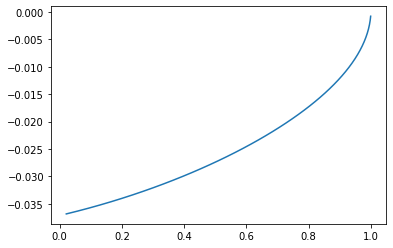

[19] loss: 0.002


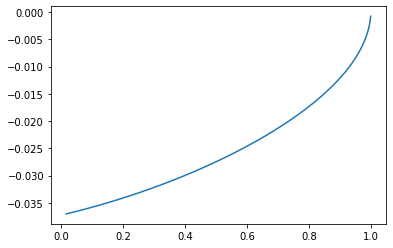

[20] loss: 0.002


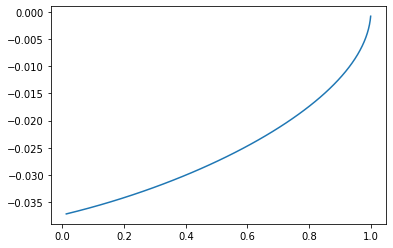

[21] loss: 0.001


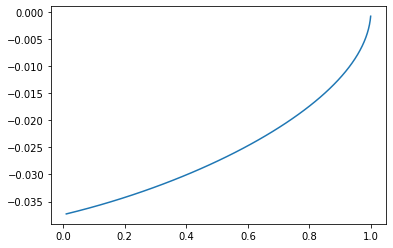

[22] loss: 0.001


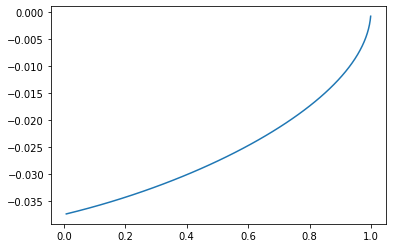

[23] loss: 0.001


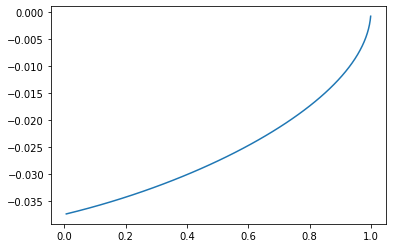

[24] loss: 0.001


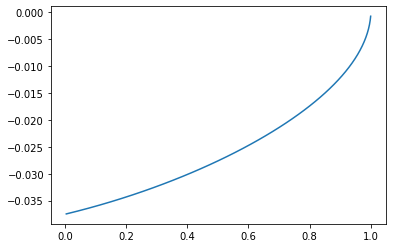

[25] loss: 0.001


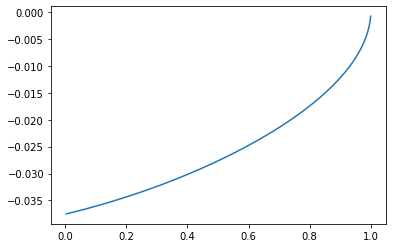

[26] loss: 0.001


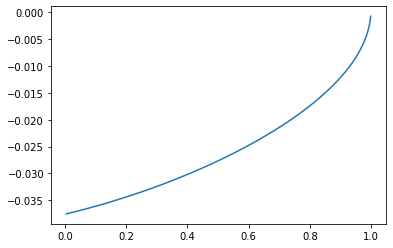

[27] loss: 0.001


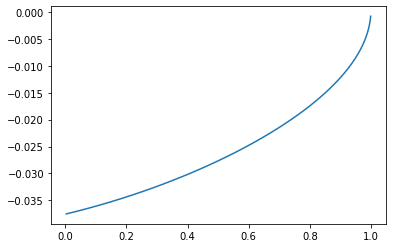

[28] loss: 0.001


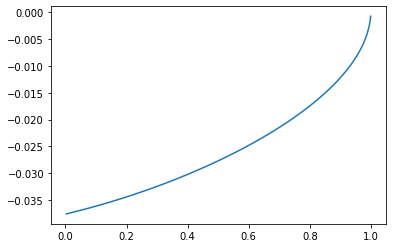

[29] loss: 0.001


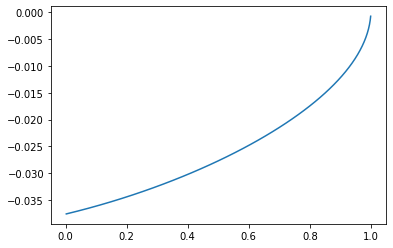

[30] loss: 0.001


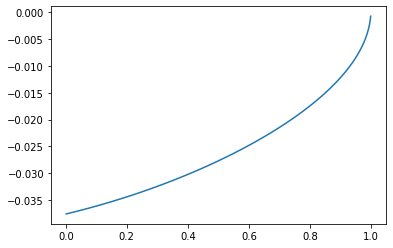

[31] loss: 0.001


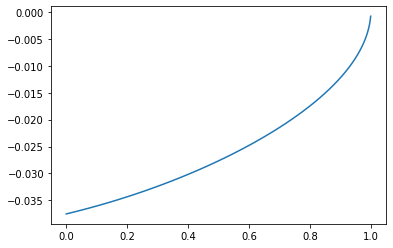

[32] loss: 0.001


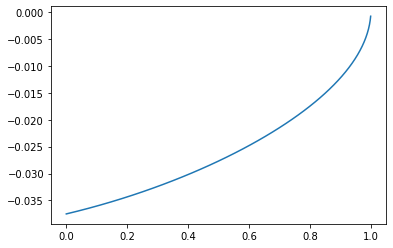

[33] loss: 0.001


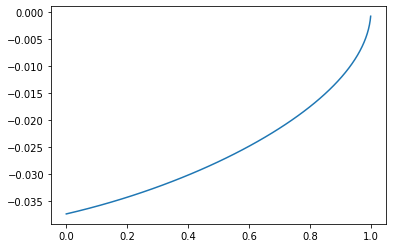

[34] loss: 0.001


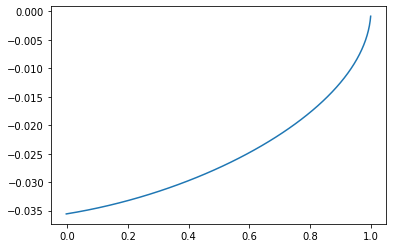

[35] loss: 0.001


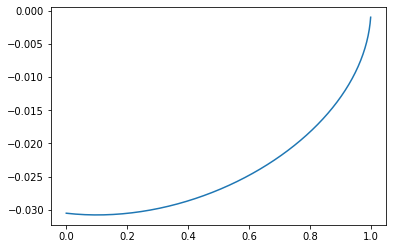

[36] loss: 0.000


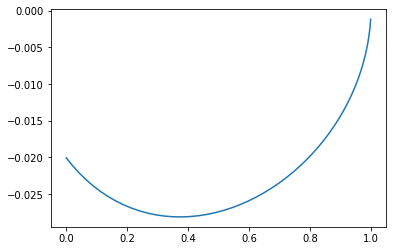

[37] loss: 0.000


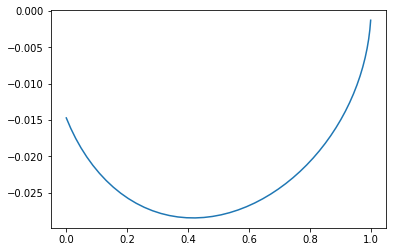

[38] loss: 0.000


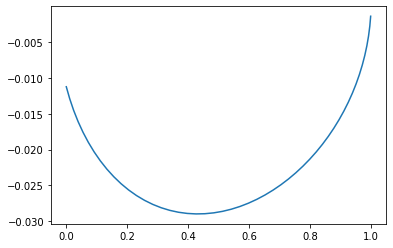

[39] loss: 0.000


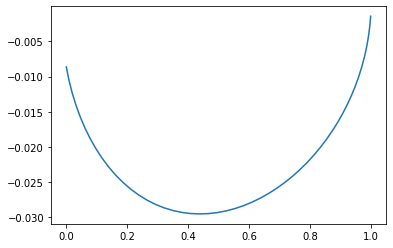

[40] loss: 0.000


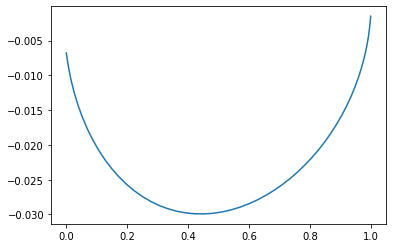

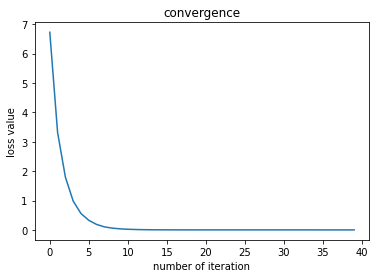

In [87]:
T = 50  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem
plt.title('convergence')
plt.ylabel('loss value')
plt.xlabel('number of iteration')
plt.plot(list(range(40)), o.l)
plt.show()

For the rocket to land we must bring the rocket state (i.e) its position and velocity to be zero. So during the final time $T$ the rocket state variables $d(t)$ and $v(t)$ should be zero. When we see the graph during consecutive iterations, we can see that the distance and velocity is gradually reaching zero and the convergence graph shows that the loss function is minimized and thus indicates that rocket reached the ground at final time $T$.